In [174]:
%matplotlib inline
#basic python packages for plotting and array management
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from datetime import timedelta

#for data import
import pandas as pd
from __future__ import division
import os
import sys
from importlib import reload
reload(sys)

#Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

#Classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, PassiveAggressiveClassifier, Perceptron, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier

#Ensemble methods and crossvalidation
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier,RandomForestClassifier, VotingClassifier

#PostProcessing
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import time

In [44]:
customers = pd.read_csv("customers6.csv")
products = pd.read_csv("products.csv")
X_train = pd.read_csv("X_train.csv")
X_test   = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")

# Preprocessing

#### Preprocessing customers

In [45]:
customers['BirthDate'] = customers['BirthDate'].apply(lambda x : datetime.strptime(x, '%d/%m/%Y %H:%M') )
age =2015 - customers['BirthDate'].apply(lambda x : x.year)
customers['BirthDate'] = age

In [46]:
customers['FirstOrderDate'] = customers['FirstOrderDate'].apply(lambda x : datetime.strptime(x, '%d/%m/%Y %H:%M') )
yearFirstOrder = customers['FirstOrderDate'].apply(lambda x : x.year)
customers['YearFirstOrder'] = yearFirstOrder
del customers['FirstOrderDate']

In [32]:
customers.head()

,CustomerId,CountryISOCode,Gender,Age,YearFirstOrder
0,17860216.0,GB,Femme,0,2015
1,10588204.0,FR,Femme,0,2015
2,17841489.0,DE,Homme,0,2015
3,17849688.0,DE,Homme,0,2015
4,12916644.0,FR,Femme,0,2012


#### Preprocessing products

In [47]:
# Preprocessing Products
col = products['SizeAdviceDescription'].eq('Prenez votre pointure habituelle').astype('float')
col1 = products['SizeAdviceDescription'].eq(products['SizeAdviceDescription'][7]).astype('float')
products['SizeAdviceDescription'] = col+col1

In [4]:
products.head()

,VariantId,GenderLabel,MarketTargetLabel,SeasonLabel,SeasonalityLabel,BrandId,UniverseLabel,TypeBrand,ProductId,ProductType,...,UpperHeight,HeelHeight,PurchasePriceHT,IsNewCollection,SubtypeLabel,UpperMaterialLabel,LiningMaterialLabel,OutSoleMaterialLabel,RemovableSole,SizeAdviceDescription
0,728257.0,Homme,Classique,Automne/Hiver,Saisonnier,66.0,DÃ©tente,Standard,17267.0,Baskets,...,NaN,0.0,30.50,0.0,Montantes,NaN,NaN,NaN,False,0.0
1,806356.0,Femme,ND,Automne/Hiver,Saisonnier,842.0,ND,Standard,30824.0,Baskets,...,0.0,0.0,43.00,0.0,Montantes,NaN,NaN,NaN,True,1.0
2,768790.0,Femme,ND,Automne/Hiver,Reconduit,988.0,Ville,Standard,62475.0,Bottines et boots,...,6.0,3.0,54.90,0.0,Bout pointu,NaN,NaN,NaN,False,1.0
3,515679.0,Femme,ND,Automne/Hiver,Saisonnier,769.0,Ville,Standard,43983.0,Escarpins,...,0.0,13.0,34.50,0.0,Bout rond,NaN,NaN,NaN,False,1.0
4,1025246.0,Femme,ND,Automne/Hiver,Saisonnier,1244.0,ND,Standard,81493.0,Bottines et boots,...,8.0,4.0,43.76,0.0,Bout rond,NaN,NaN,NaN,False,1.0


# Merging

In [48]:
index = pd.DataFrame({'index':np.arange(X_train.shape[0])})
X_train['index']=index # Evite les duplicata
y_train['index']=index

In [49]:
X_Product = pd.merge(X_train,products,how='left',on='VariantId')
X_data = pd.merge(X_Product,customers,how='left',on='CustomerId')
data = pd.merge(y_train,X_data,how='left',on="index")
data = data.sort_values(by='index')
data.head()

,OrderNumber_x,LineItem_x,ReturnQuantity,ReturnQuantityBin,index,OrderNumber_y,VariantId,LineItem_y,CustomerId,OrderStatusLabel,...,SubtypeLabel,UpperMaterialLabel,LiningMaterialLabel,OutSoleMaterialLabel,RemovableSole,SizeAdviceDescription,CountryISOCode,BirthDate,Gender,YearFirstOrder
0,73521754,1,0.0,0.0,0,73521754,439729,1,12443972,Expédié,...,NaN,NaN,NaN,NaN,NaN,NaN,FR,57.0,Femme,2011.0
1,73521754,2,0.0,0.0,1,73521754,440174,2,12443972,Expédié,...,NaN,NaN,NaN,NaN,NaN,NaN,FR,57.0,Femme,2011.0
2,73525226,1,1.0,1.0,2,73525226,494501,1,12443958,Expédié,...,Bout rond,NaN,NaN,NaN,False,1.0,FR,43.0,Femme,2011.0
3,73529009,1,1.0,1.0,3,73529009,439590,1,12443946,Expédié,...,NaN,NaN,NaN,NaN,NaN,NaN,FR,45.0,Femme,2011.0
4,73529009,2,1.0,1.0,4,73529009,559476,2,12443946,Expédié,...,Bout rond,Cuir,NaN,NaN,False,1.0,FR,45.0,Femme,2011.0


In [50]:
one = pd.Series(1,index = range(data.shape[0]))
data['one']=one

In [51]:
data.columns.values

array(['OrderNumber_x', 'LineItem_x', 'ReturnQuantity',
       'ReturnQuantityBin', 'index', 'OrderNumber_y', 'VariantId',
       'LineItem_y', 'CustomerId', 'OrderStatusLabel', 'OrderTypelabel',
       'SeasonLabel_x', 'PayementModeLabel', 'CustomerTypeLabel',
       'IsoCode', 'DeviceTypeLabel', 'PricingTypeLabel', 'TotalLineItems',
       'Quantity', 'UnitPMPEUR', 'OrderCreationDate', 'OrderShipDate',
       'OrderNumCustomer', 'IsOnSale', 'BillingPostalCode', 'GenderLabel',
       'MarketTargetLabel', 'SeasonLabel_y', 'SeasonalityLabel', 'BrandId',
       'UniverseLabel', 'TypeBrand', 'ProductId', 'ProductType',
       'SupplierColor', 'ProductColorId', 'MinSize', 'MaxSize', 'CalfTurn',
       'UpperHeight', 'HeelHeight', 'PurchasePriceHT', 'IsNewCollection',
       'SubtypeLabel', 'UpperMaterialLabel', 'LiningMaterialLabel',
       'OutSoleMaterialLabel', 'RemovableSole', 'SizeAdviceDescription',
       'CountryISOCode', 'BirthDate', 'Gender', 'YearFirstOrder', 'one'], dtype=objec

In [52]:
returndata = data[data['ReturnQuantityBin']==1]

# Correlation

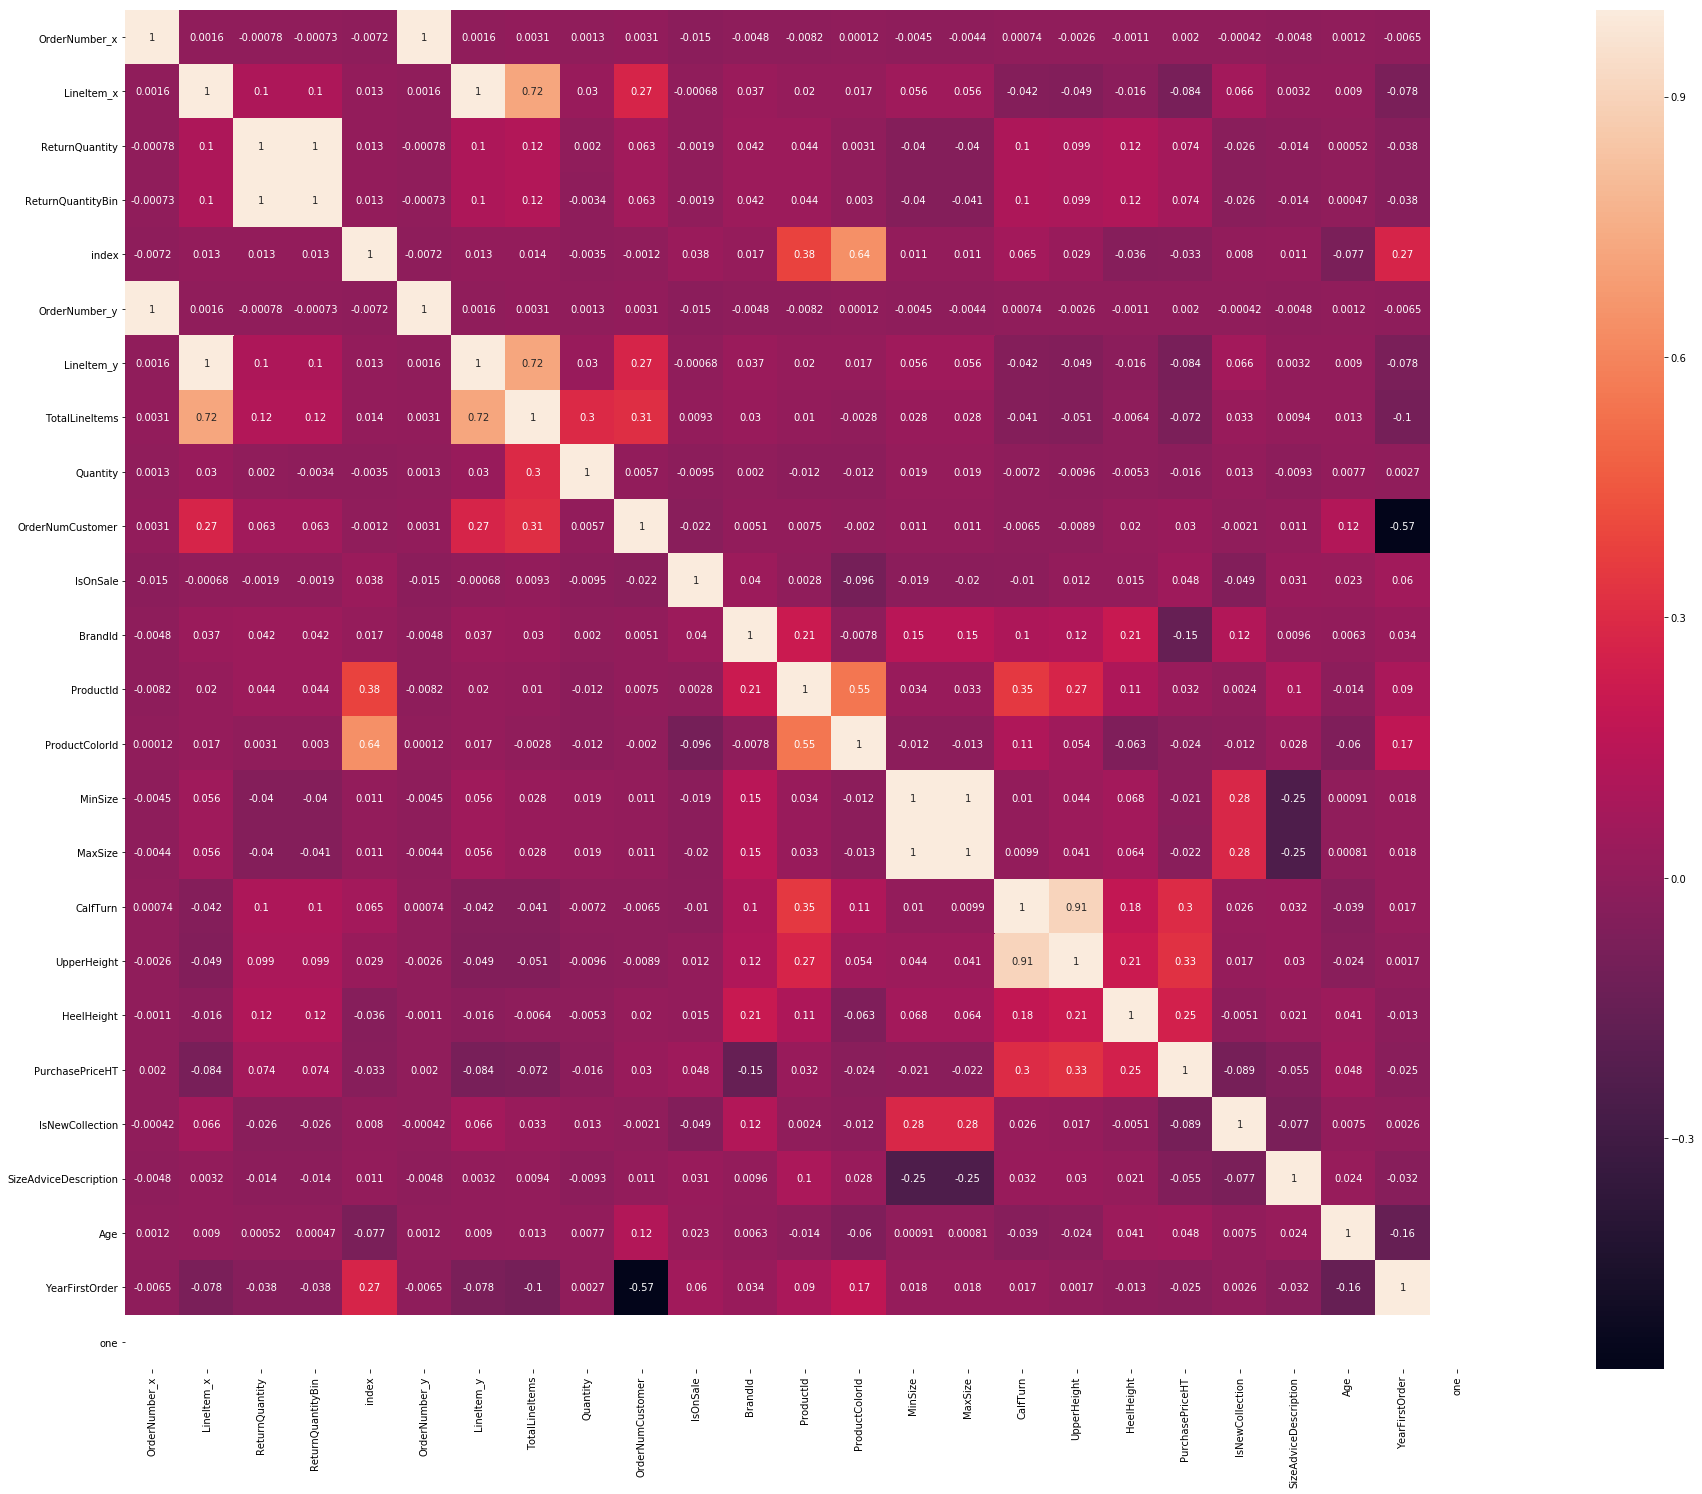

In [39]:
correlation = data.corr(method='pearson')
plt.figure(figsize=(40,25))
sns.heatmap(correlation, vmax=1, square=True,  annot=True ) 
plt.show()

# Visualization 

In [200]:
def autolabel(rects,p):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            p.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                '%f' %height,
                ha='center', va='bottom')

def histogramme (column):
    d = pd.crosstab(data['one'],data[column],normalize='index')
    returnd = pd.crosstab(returndata['one'],returndata[column],normalize='index')
    label = d.columns.tolist()
    returnlabel = returnd.columns.tolist()
    liste1 = d.values[0]
    liste2 = returnd.values[0]
    
    # Avoid errors
    if (len(label)!=len(returnlabel)):
        delta = len(label)-len(returnlabel) #nombre de 0 qu'on ajoute à la fin de returndata
        for k in range(delta):
            returnlabel.append(0)
            liste2 = np.append(liste2,[0])   

        indice = []
        deltabis = delta
        for k in range (len(label)):
            if (label[k]!=returnlabel[k]):
                indice.append(k)# position des labels manquants
                returnlabel[len(returnlabel)-deltabis]=label[k]
                liste2[len(liste2)-deltabis]=liste1[k]
                deltabis = deltabis-1

        
        deltatri = delta
        for j in range(len(indice)):
            ind = indice[j]
            pivot = returnlabel[ind]
            pivotvalue = liste2[ind]
            returnlabel.insert(indice[j],returnlabel[len(returnlabel)-deltatri])
            liste2 = np.insert(liste2,indice[j],liste2[len(liste2)-deltatri])
            deltatri = deltatri-1

        for i in range(delta):
            del returnlabel[-1]
            liste2 = np.delete(liste2,-1)
    
    
    
    # Plot the scores
    N = len(label)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    sns.set(style='darkgrid')
    fig, ax = plt.subplots(figsize=(20, 10))

    rects1 = ax.bar(ind, liste1, width, color='indianred')
    rects2 = ax.bar(ind + width, liste2, width, color='seagreen')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Ratio')
    ax.set_title('Ratio for data and returned data')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(label,rotation=90)
    ax.legend((rects1[0], rects2[0]), ('Data', 'Return Data'))
    
    autolabel(rects1,ax)
    autolabel(rects2,ax)

    plt.show()    
    
def percent (column):
    d = pd.crosstab(data['one'],data[column],normalize='index')
    returnd = pd.crosstab(returndata['one'],returndata[column],normalize='index')
    label = d.columns.tolist()
    returnlabel = returnd.columns.tolist()
    liste1 = d.values[0]
    liste2 = returnd.values[0]
    
    # Avoid errors
    if (len(label)!=len(returnlabel)):
        delta = len(label)-len(returnlabel) #nombre de 0 qu'on ajoute à la fin de returndata
        for k in range(delta):
            returnlabel.append(0)
            liste2 = np.append(liste2,[0])   

        indice = []
        deltabis = delta
        for k in range (len(label)):
            if (label[k]!=returnlabel[k]):
                indice.append(k)# position des labels manquants
                returnlabel[len(returnlabel)-deltabis]=label[k]
                liste2[len(liste2)-deltabis]=liste1[k]
                deltabis = deltabis-1

        
        deltatri = delta
        for j in range(len(indice)):
            ind = indice[j]
            pivot = returnlabel[ind]
            pivotvalue = liste2[ind]
            returnlabel.insert(indice[j],returnlabel[len(returnlabel)-deltatri])
            liste2 = np.insert(liste2,indice[j],liste2[len(liste2)-deltatri])
            deltatri = deltatri-1

        for i in range(delta):
            del returnlabel[-1]
            liste2 = np.delete(liste2,-1)
    
    pourcentage = []
    for i in range(len(liste1)):
        pourcentage.append((liste2[i]-liste1[i])*100/(liste1[i]))

    
    # Plot the scores
    N = len(label)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    sns.set(style='darkgrid')
    fig, ax = plt.subplots(figsize=(20, 10))

    rects1 = ax.bar(ind, pourcentage, width,color='firebrick')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Percent')
    ax.set_title('Percent change')
    ax.set_xticks(ind)
    ax.set_xticklabels(label,rotation=90)
    ax.legend(label)
    
    autolabel(rects1,ax)
    plt.show()

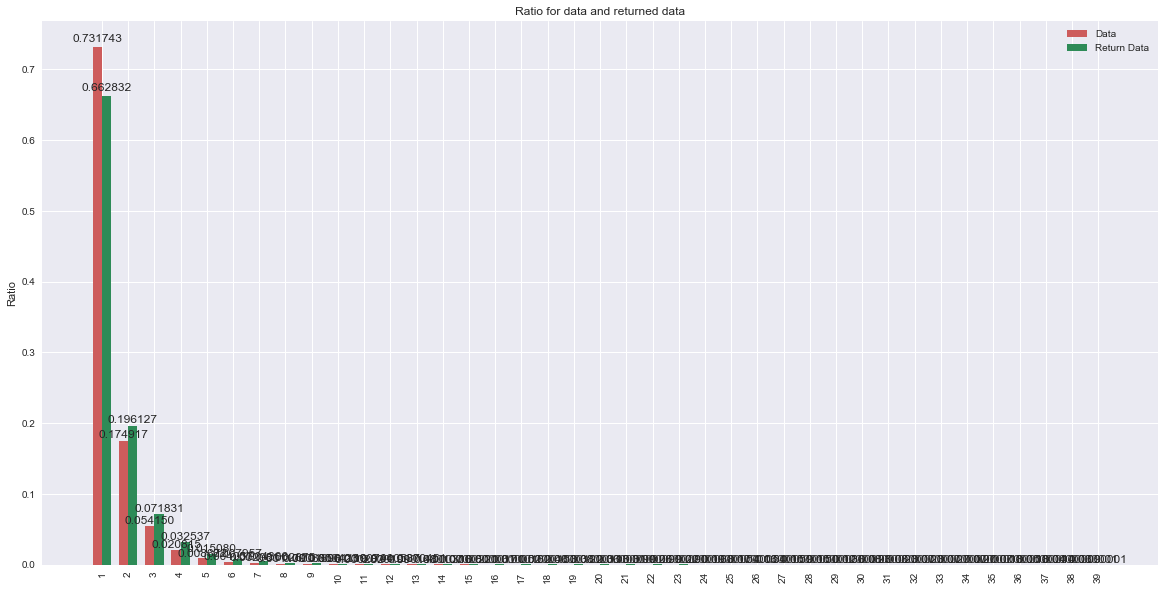

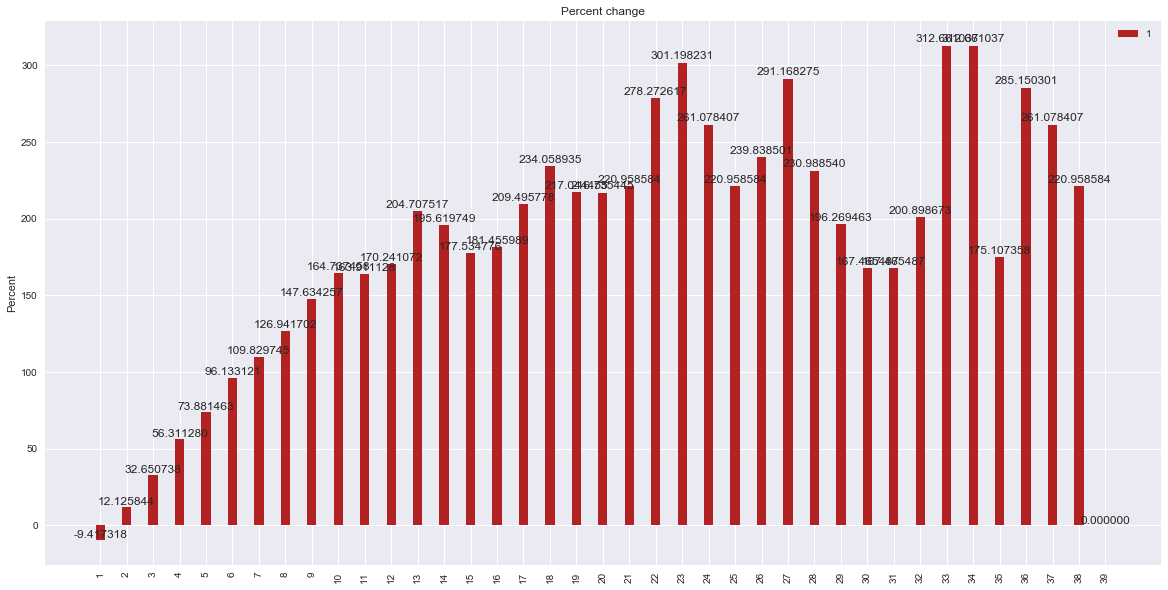

In [201]:
histogramme('LineItem_x')
percent('LineItem_x')

## Products

##### Price HT

In [64]:
print('pour les prix entre 0 et 20€')
# Pour toutes les données
price020 = ((data['PurchasePriceHT']>0) & (data['PurchasePriceHT']<20)).sum()/(data.shape[0])
print(price020)

# Pour les données retournées
price020return = ((returndata['PurchasePriceHT']>0) & (returndata['PurchasePriceHT']<20)).sum()/(returndata.shape[0])
print(price020return)

print('\npour les prix entre 20 et 40€')
# Pour toutes les données
price = ((data['PurchasePriceHT']>20) & (data['PurchasePriceHT']<40)).sum()/(data.shape[0])
print(price)

# Pour les données retournées
pricereturn = ((returndata['PurchasePriceHT']>20) & (returndata['PurchasePriceHT']<40)).sum()/(returndata.shape[0])
print(pricereturn)

print('\npour les prix entre 40 et 60€')
# Pour toutes les données
price = ((data['PurchasePriceHT']>40) & (data['PurchasePriceHT']<60)).sum()/(data.shape[0])
print(price)

# Pour les données retournées
pricereturn = ((returndata['PurchasePriceHT']>40) & (returndata['PurchasePriceHT']<60)).sum()/(returndata.shape[0])
print(pricereturn)

print('\npour les prix entre 60 et 80€')
# Pour toutes les données
price = ((data['PurchasePriceHT']>60) & (data['PurchasePriceHT']<80)).sum()/(data.shape[0])
print(price)

# Pour les données retournées
pricereturn = ((returndata['PurchasePriceHT']>60) & (returndata['PurchasePriceHT']<80)).sum()/(returndata.shape[0])
print(pricereturn)

pour les prix entre 0 et 20€
0.155964170938
0.128892858432

pour les prix entre 20 et 40€
0.295360211376
0.30245660568

pour les prix entre 40 et 60€
0.133006961557
0.152421421096

pour les prix entre 60 et 80€
0.0341912694769
0.0433988307892


##### SeasonLabel

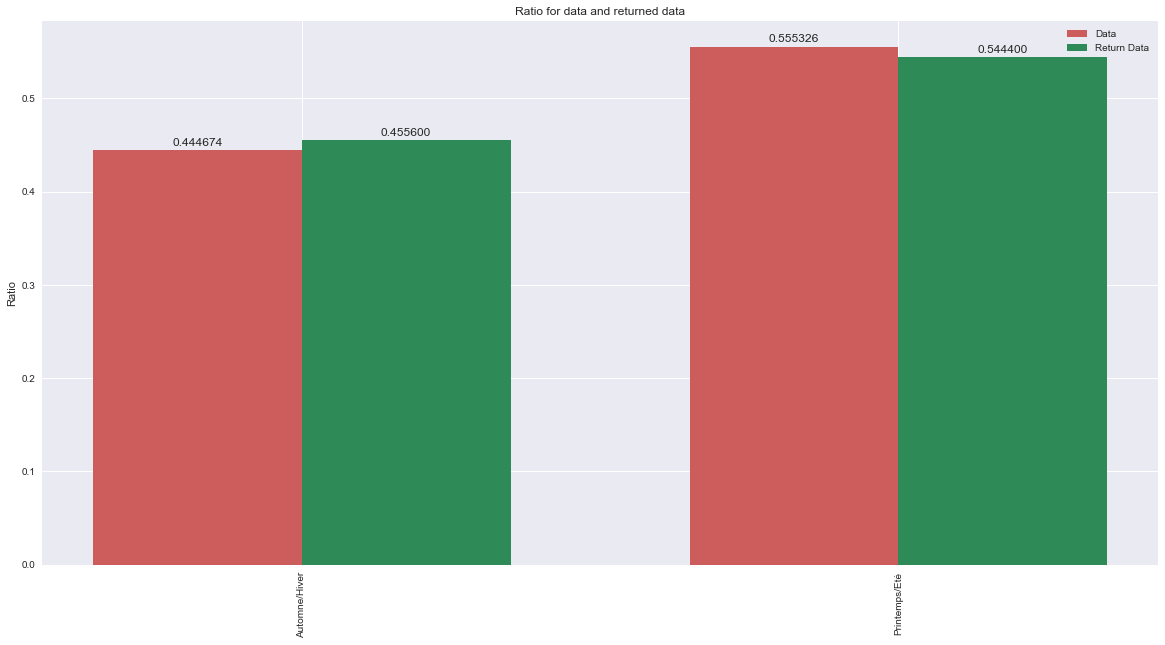

In [117]:
histogramme('SeasonLabel_x')

##### GenderLabel

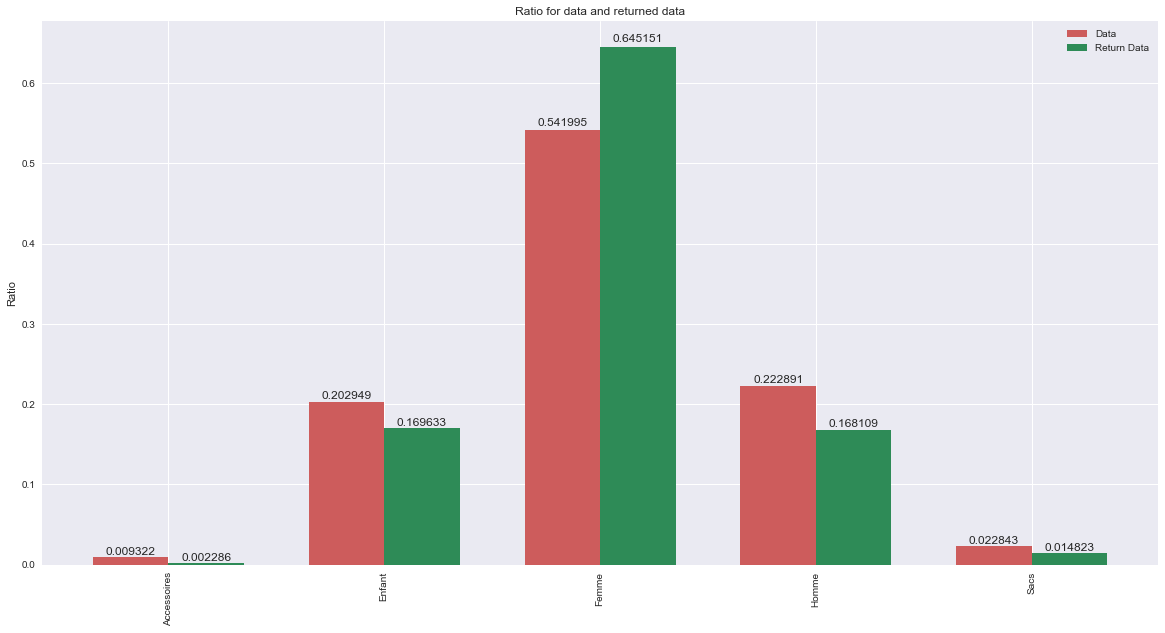

In [115]:
histogramme('GenderLabel')

###### Size advice description

In [15]:
# Pour toutes les données
d = ((data['SizeAdviceDescription'] == 1).sum())/(data.shape[0])
print(d)

# Pour les données retournées
dreturn = ((returndata['SizeAdviceDescription'] == 1).sum())/(returndata.shape[0])
print(dreturn)

0.40445989375
0.406142867453


###### UniverseLabel

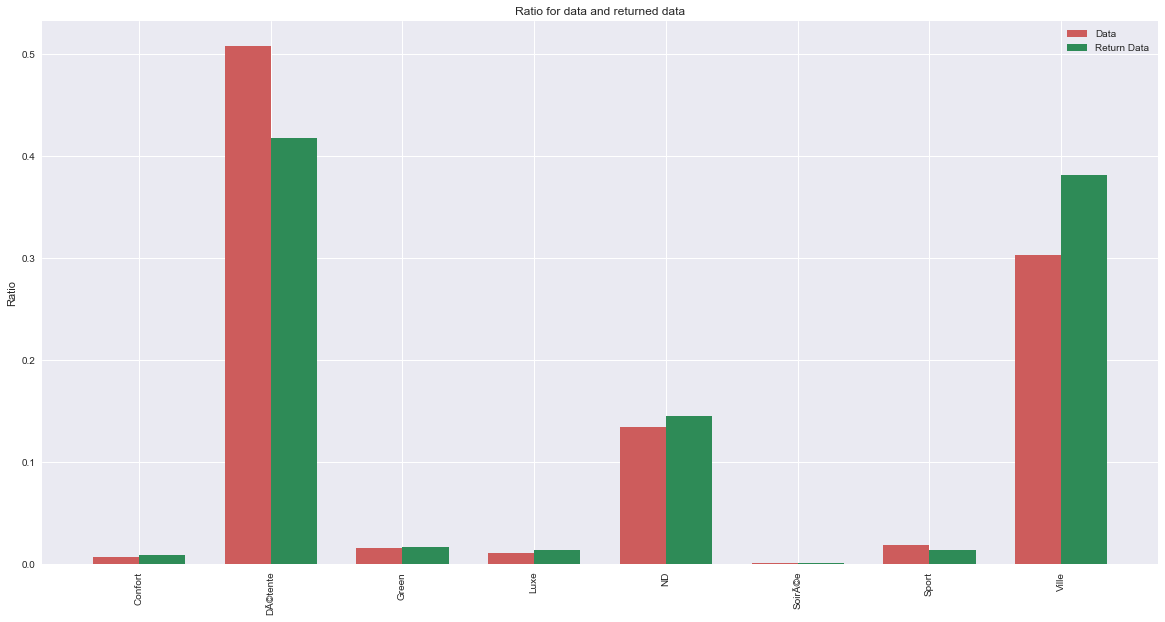

In [133]:
histogramme('UniverseLabel')

###### Product Type

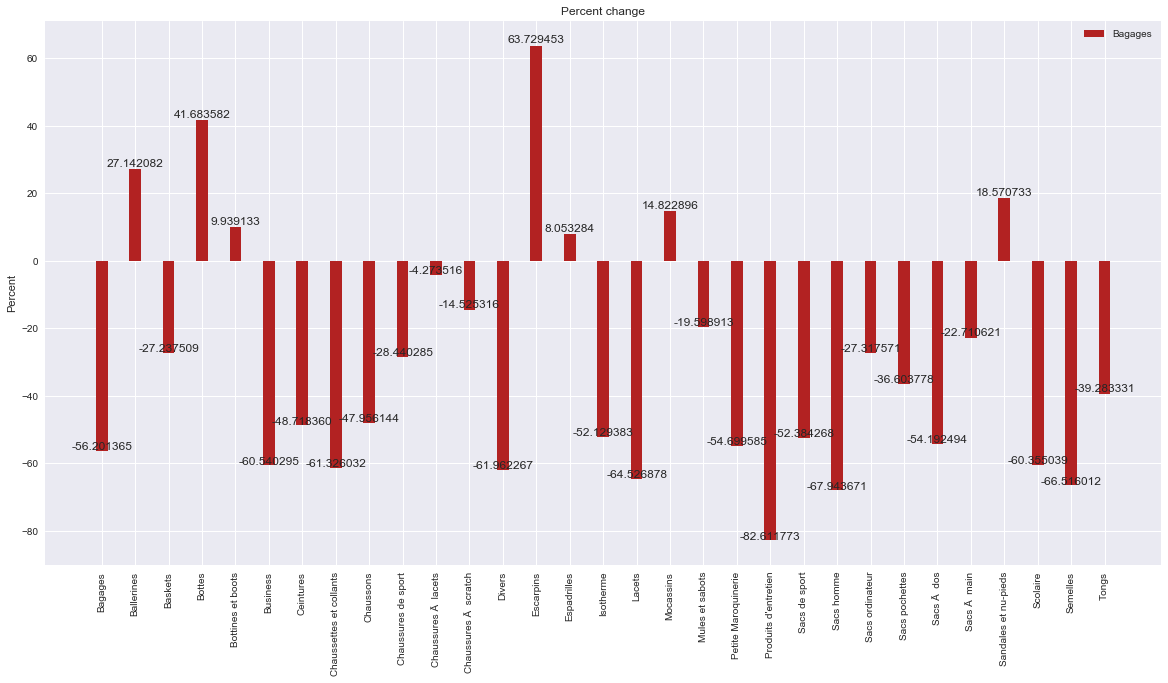

In [98]:
percent('ProductType')

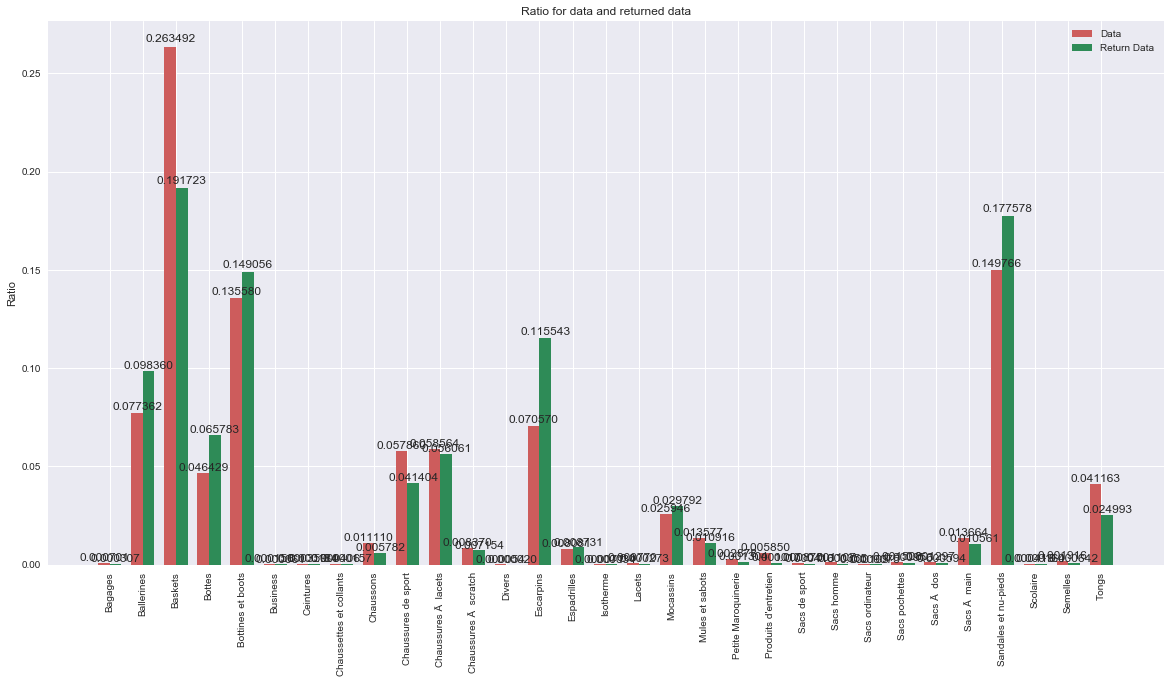

In [97]:
histogramme('ProductType')

# Customers

##### FirstOrderDate

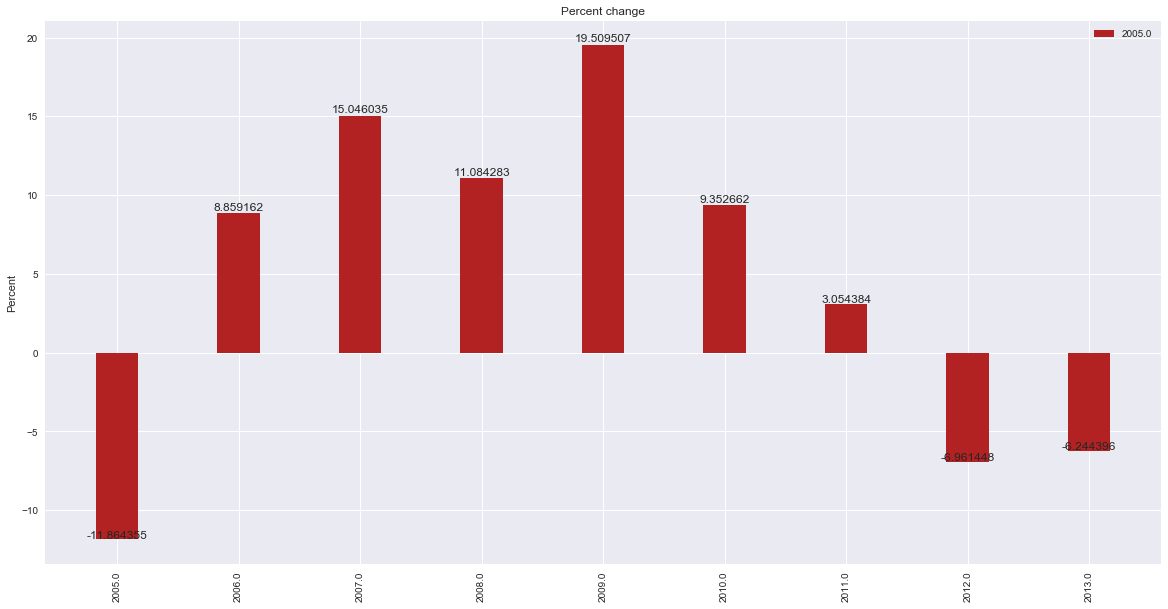

In [96]:
percent('YearFirstOrder')

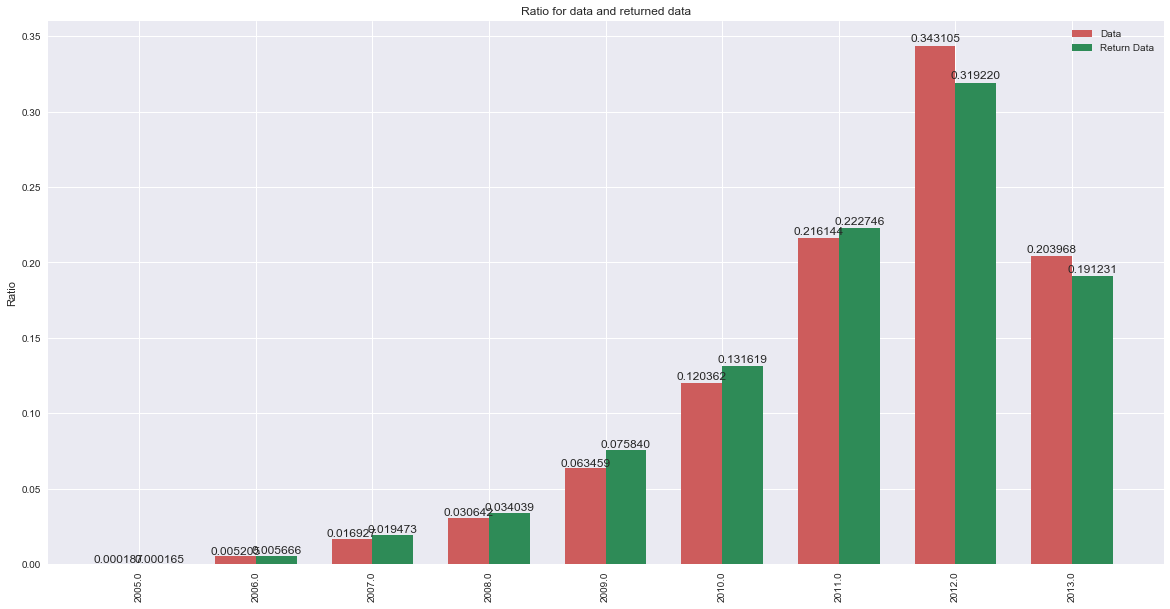

In [93]:
histogramme('YearFirstOrder')

##### Birthdate -> Age

In [104]:
age1015 = ((data['BirthDate']>10) & (data['BirthDate']<15)).sum()
age1520 = ((data['BirthDate']>15) & (data['BirthDate']<20)).sum()
age2025 = ((data['BirthDate']>20) & (data['BirthDate']<25)).sum()
age2530 = ((data['BirthDate']>25) & (data['BirthDate']<30)).sum()
age3035 = ((data['BirthDate']>30) & (data['BirthDate']<35)).sum()
age3540 = ((data['BirthDate']>35) & (data['BirthDate']<40)).sum()
age4045 = ((data['BirthDate']>40) & (data['BirthDate']<45)).sum()
age4550 = ((data['BirthDate']>45) & (data['BirthDate']<50)).sum()
age5055 = ((data['BirthDate']>50) & (data['BirthDate']<55)).sum()
age5560 = ((data['BirthDate']>55) & (data['BirthDate']<60)).sum()
    
age = [age1015,age1520,age2025,age2530,age3035,age3540,age4045,age4550,age5055,age5560]

returnage1015 = ((returndata['BirthDate']>10) & (returndata['BirthDate']<15)).sum()
returnage1520 = ((returndata['BirthDate']>15) & (returndata['BirthDate']<20)).sum()
returnage2025 = ((returndata['BirthDate']>20) & (returndata['BirthDate']<25)).sum()
returnage2530 = ((returndata['BirthDate']>25) & (returndata['BirthDate']<30)).sum()
returnage3035 = ((returndata['BirthDate']>30) & (returndata['BirthDate']<35)).sum()
returnage3540 = ((returndata['BirthDate']>35) & (returndata['BirthDate']<40)).sum()
returnage4045 = ((returndata['BirthDate']>40) & (returndata['BirthDate']<45)).sum()
returnage4550 = ((returndata['BirthDate']>45) & (returndata['BirthDate']<50)).sum()
returnage5055 = ((returndata['BirthDate']>50) & (returndata['BirthDate']<55)).sum()
returnage5560 = ((returndata['BirthDate']>55) & (returndata['BirthDate']<60)).sum()
    
returnage = [returnage1015,returnage1520,returnage2025,returnage2530,returnage3035,returnage3540,returnage4045,returnage4550,returnage5055,returnage5560]

ratio = []
ratioreturn = []
for j in range (len(age)):
    #print('\nAge du consomateur entre :%f et %f',%(10+5*j) %(10+5*(j+1)))
    ratio.append(age[j]/(data.shape[0]))
    ratioreturn.append(returnage[j]/(returndata.shape[0]))

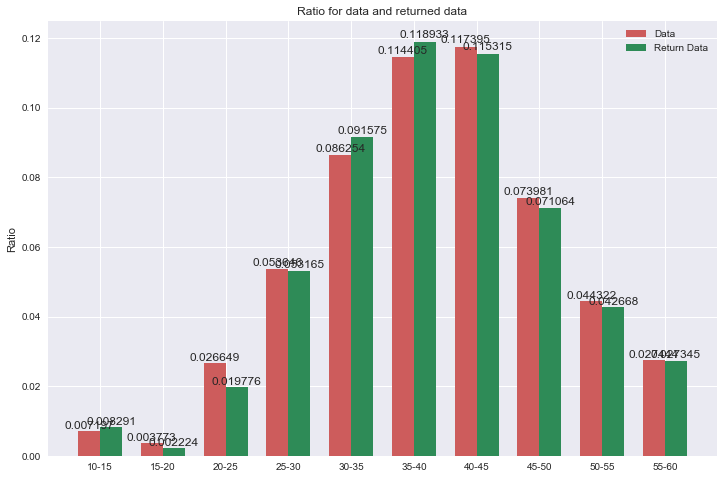

In [66]:
# Plot the scores
N = len(ratio)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(ind, ratio, width, color='indianred')
rects2 = ax.bar(ind + width, ratioreturn, width, color='seagreen')

# add some text for labels, title and axes ticks
ax.set_ylabel('Ratio')
ax.set_title('Ratio for data and returned data')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('10-15', '15-20', '20-25', '25-30','30-35','35-40','40-45','45-50','50-55','55-60'))
ax.legend((rects1[0], rects2[0]), ('Data', 'Return Data'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                '%f' %height,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

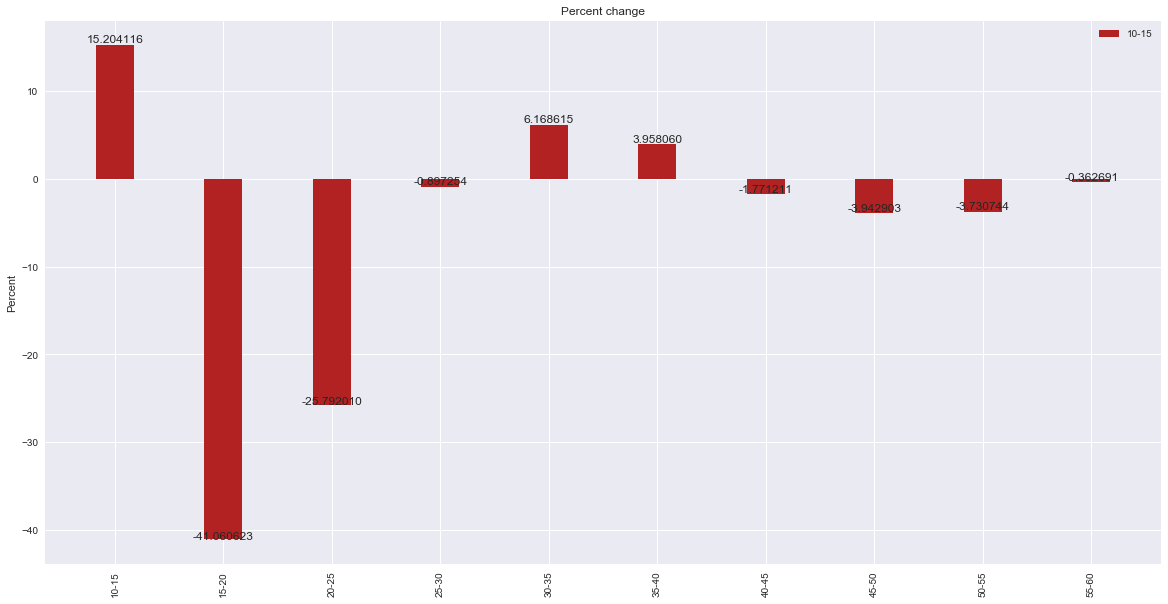

In [110]:
label=['10-15', '15-20', '20-25', '25-30','30-35','35-40','40-45','45-50','50-55','55-60']
pourcentage = []
for i in range(len(ratio)):
    pourcentage.append((ratioreturn[i]-ratio[i])*100/(ratio[i]))
# Plot the scores
N = len(label)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(ind, pourcentage, width,color='firebrick')

# add some text for labels, title and axes ticks
ax.set_ylabel('Percent')
ax.set_title('Percent change')
ax.set_xticks(ind)
ax.set_xticklabels(label,rotation=90)
ax.legend([label[0],label[1]])
    
autolabel(rects1,ax)

##### Country ISO CODE

In [68]:
pd.crosstab(data['one'],data['CountryISOCode'],normalize='index')

CountryISOCode,AT,BE,BG,CZ,DE,DK,EE,ES,FI,FR,...,LT,LU,LV,NL,PL,PT,RO,SE,SI,SK
one,,,,,,,,,,,,,,,,,,,,,
1,0.000477,0.028679,0.000028,0.000128,0.029077,0.004517,0.000032,0.019981,0.000318,0.854414,...,0.000038,0.001115,0.000025,0.0222,0.007237,0.000213,0.00014,0.003417,0.000044,0.000046


In [69]:
pd.crosstab(data['one'],returndata['CountryISOCode'],normalize='index')

CountryISOCode,AT,BE,BG,CZ,DE,DK,EE,ES,FI,FR,...,LT,LU,LV,NL,PL,PT,RO,SE,SI,SK
one,,,,,,,,,,,,,,,,,,,,,
1,0.000636,0.031264,0.000018,0.000043,0.060327,0.003967,0.000012,0.016894,0.000269,0.816812,...,0.000012,0.001015,0.000018,0.031007,0.006968,0.000098,0.000098,0.003319,0.000006,0.000037


Peu importe le pays, les femmes sont toujours celles qui renvoient le plus les commandes. Information inutile dans CountryISOCode ?

###### Gender

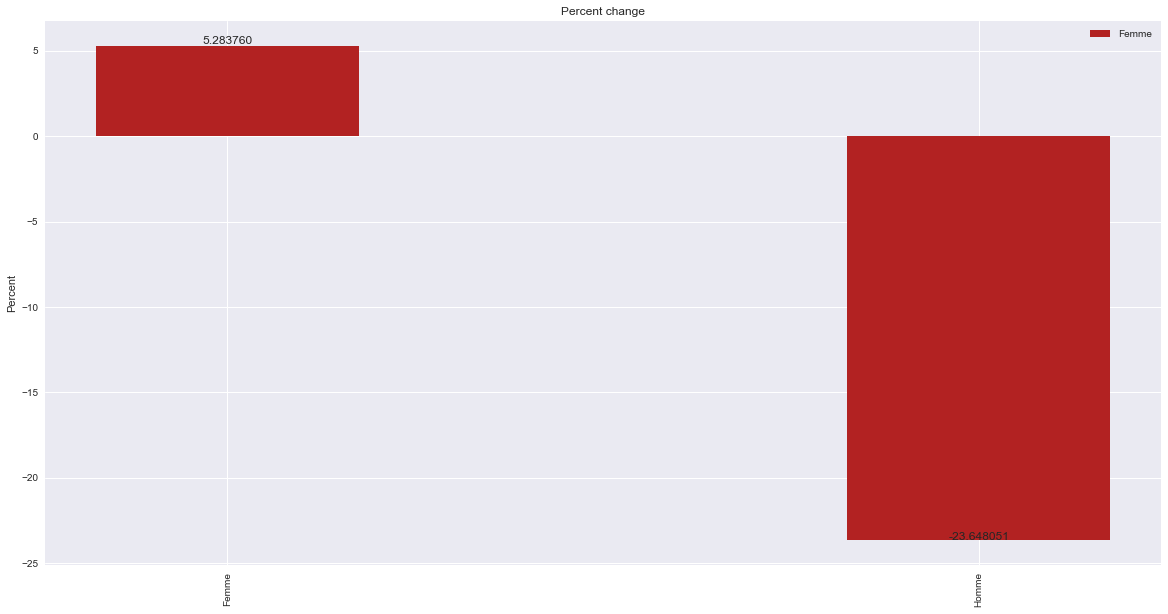

In [95]:
d = pd.crosstab(data['one'],data['Gender'],normalize='index')
returnd = pd.crosstab(returndata['one'],returndata['Gender'],normalize='index')
label = d.columns.tolist()
liste1 = d.values[0]
liste2 = returnd.values[0]
percen = []
for i in range(len(liste1)-1):
    percen.append((liste2[i]-liste1[i])*100/(liste1[i]))

    
# Plot the scores
N = len(label)-1
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(ind, percen, width,color='firebrick')

# add some text for labels, title and axes ticks
ax.set_ylabel('Percent')
ax.set_title('Percent change')
ax.set_xticks(ind)
ax.set_xticklabels(label,rotation=90)
ax.legend([label[0],label[1]])
    
autolabel(rects1,ax)

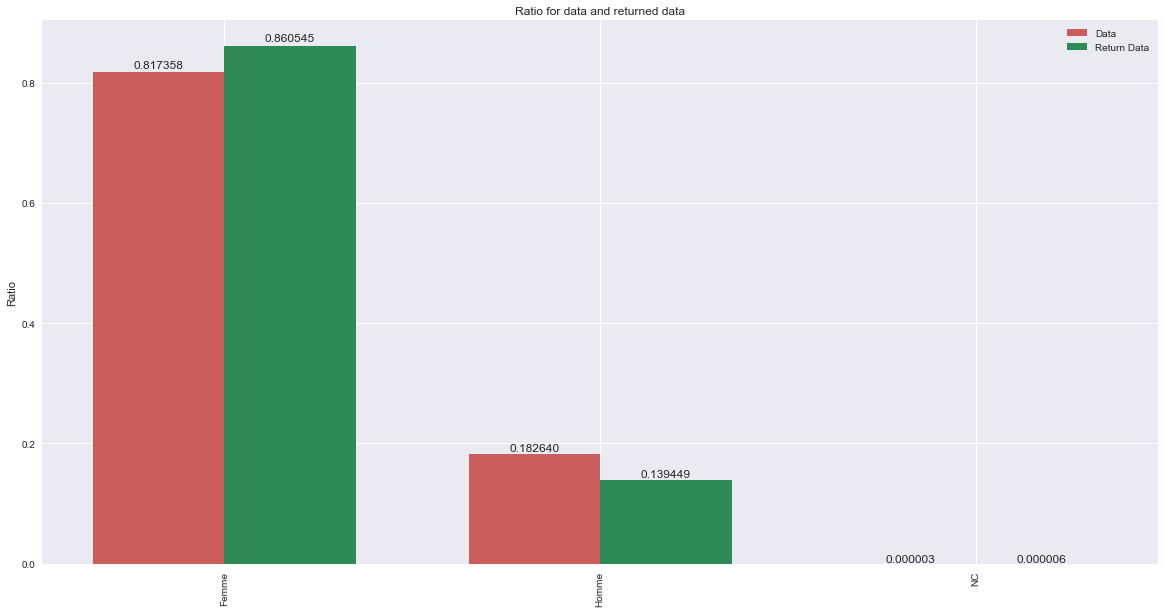

In [75]:
histogramme('Gender')

# Orders

In [129]:
returndata['LineItem_x'].value_counts()

1     146942
2      43479
3      15924
4       7213
5       3343
6       1764
7        968
8        593
9        376
10       248
11       165
12       119
13       100
14        70
15        49
16        38
17        36
18        34
19        27
20        25
21        22
22        22
23        20
24        15
27        13
25        12
26        12
28        11
29         8
33         6
34         6
30         5
31         5
32         5
36         4
35         4
37         3
38         2
Name: LineItem_x, dtype: int64

ValueError: shape mismatch: objects cannot be broadcast to a single shape

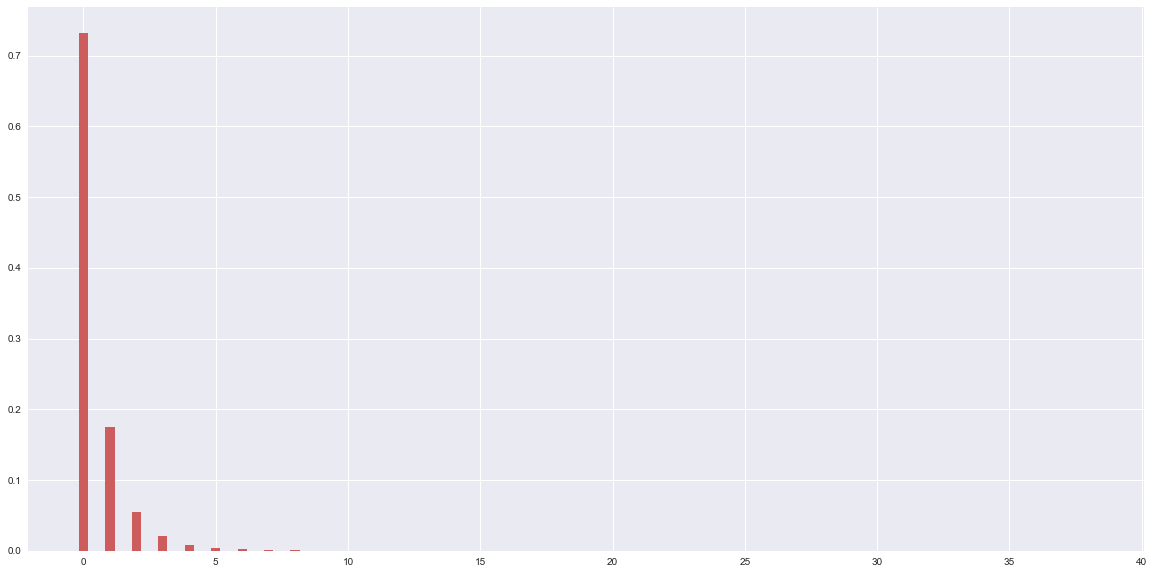

In [122]:
histogramme('LineItem_x')
percent('LineItem_x')

##### Customer type label

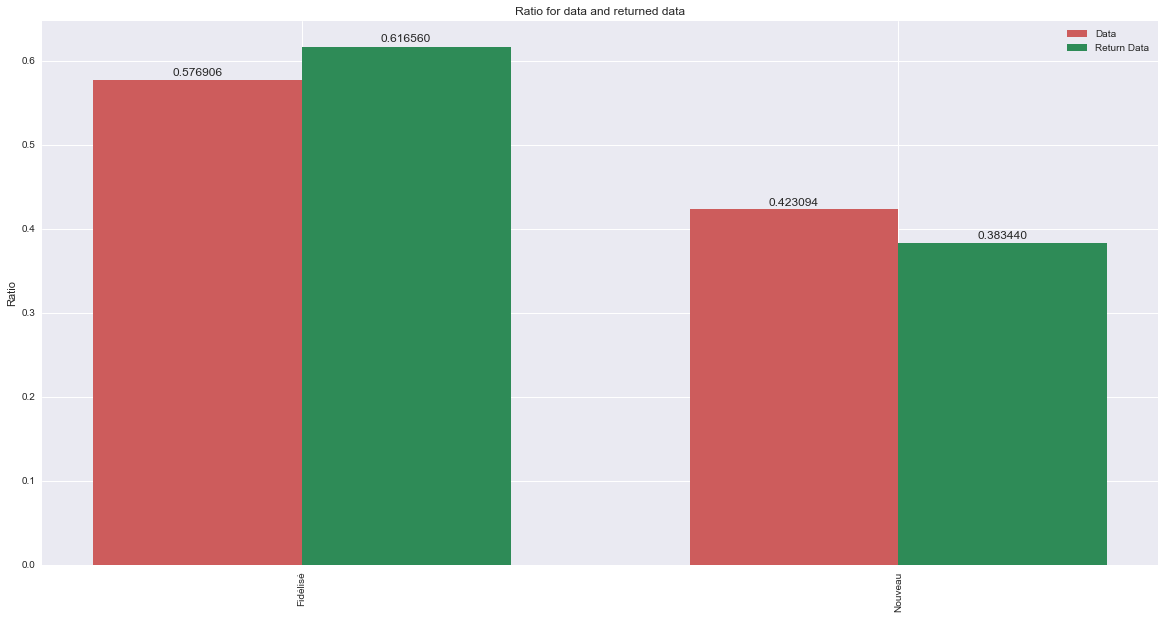

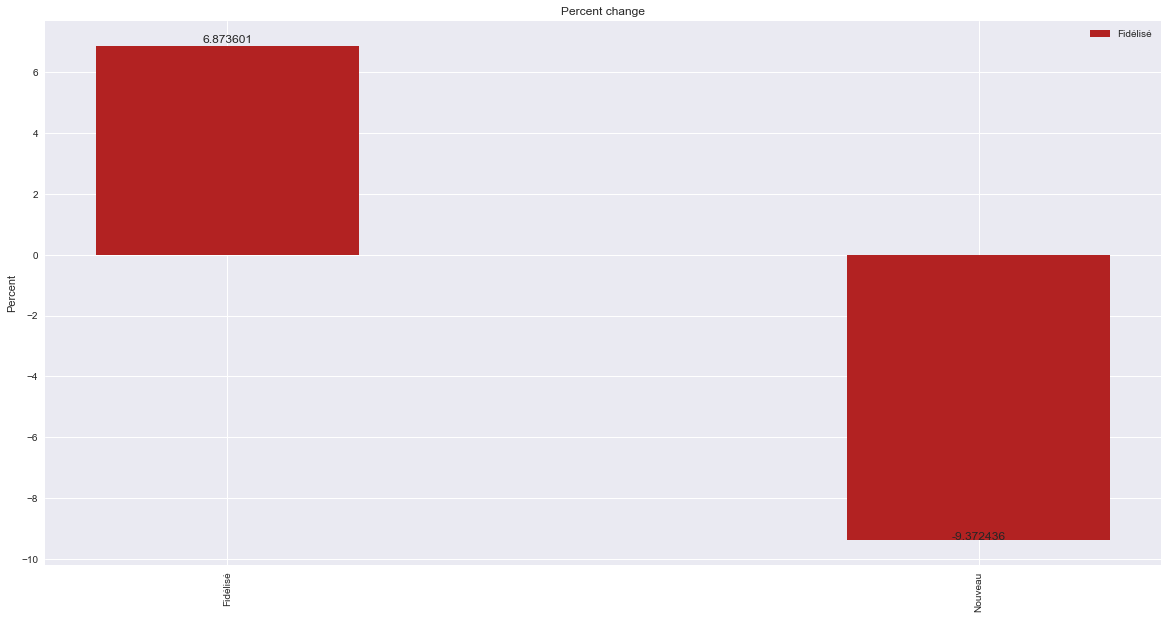

In [119]:
histogramme('CustomerTypeLabel')
percent('CustomerTypeLabel')

In [10]:
print('femmes fidélisées')
# Pour toutes les données
price = ((data['CustomerTypeLabel'] == 'Fidélisé') & (data['Gender'] == 'Femme')).sum()/(data.shape[0])
print(price)
#price = ((data['CustomerTypeLabel'] == 'Nouveau') & (data['Gender'] == 'Femme')).sum()/(data.shape[0])
#print(price)

# Pour les données retournées
pricereturn = ((returndata['CustomerTypeLabel'] == 'Fidélisé') & (returndata['Gender'] == 'Femme')).sum()/(returndata.shape[0])
print(pricereturn)

femmes fidélisées
0.38333255254
0.423211901411


In [73]:
print('hommes non fidélisées')
# Pour toutes les données
price = ((data['CustomerTypeLabel'] == 'Nouveau') & (data['Gender'] == 'Homme')).sum()/(data.shape[0])
print(price)

# Pour les données retournées
pricereturn = ((returndata['CustomerTypeLabel'] == 'Nouveau') & (returndata['Gender'] == 'Homme')).sum()/(returndata.shape[0])
print(pricereturn)

hommes non fidélisées
0.0722802612223
0.0513153621306


In [22]:
pd.crosstab(data['Gender'],data['CustomerTypeLabel'],normalize='all')

CustomerTypeLabel,Fidélisé,Nouveau
Gender,,
Femme,0.517612,0.299746
Homme,0.085040,0.097600
NC,0.000003,0.000000


In [23]:
pd.crosstab(returndata['Gender'],returndata['CustomerTypeLabel'],normalize='all')

CustomerTypeLabel,Fidélisé,Nouveau
Gender,,
Femme,0.573450,0.287095
Homme,0.069917,0.069532
NC,0.000006,0.000000


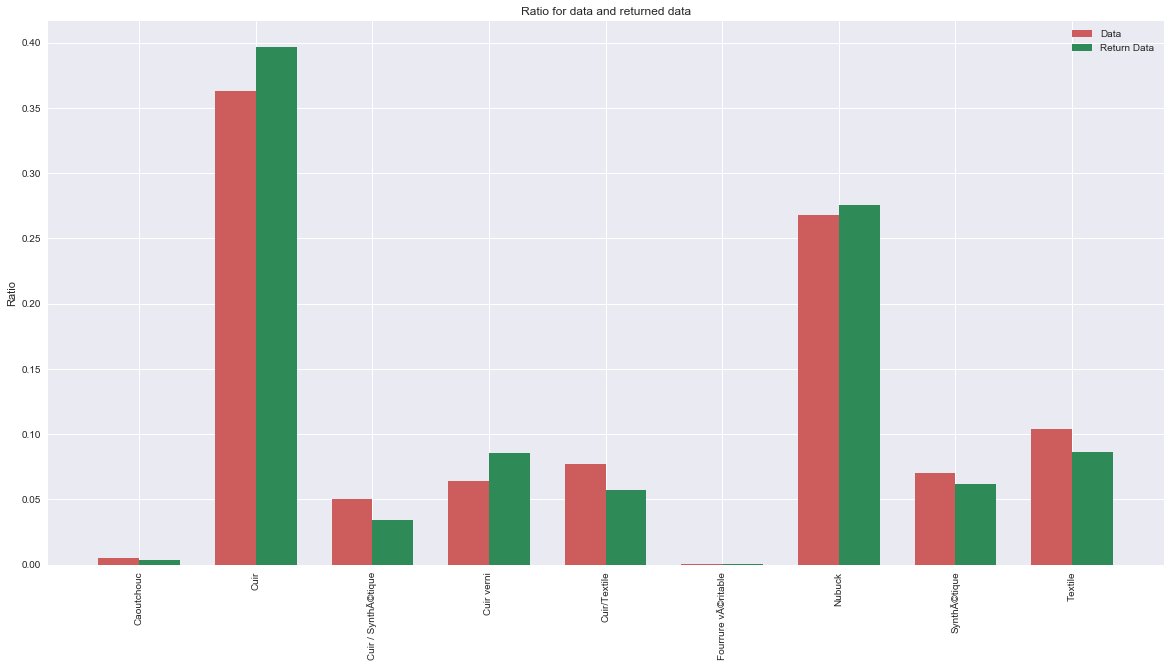

In [152]:
histogramme('UpperMaterialLabel')

### Time serie

###### Mois de la commande

In [23]:
# add new columns for the month
data['OrderCreationDate'] = data['OrderCreationDate'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S') )
ds = data['OrderCreationDate'].apply(lambda x : x.month)
returndata['OrderCreationDate'] = returndata['OrderCreationDate'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S') )
dsreturn = returndata['OrderCreationDate'].apply(lambda x : x.month)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


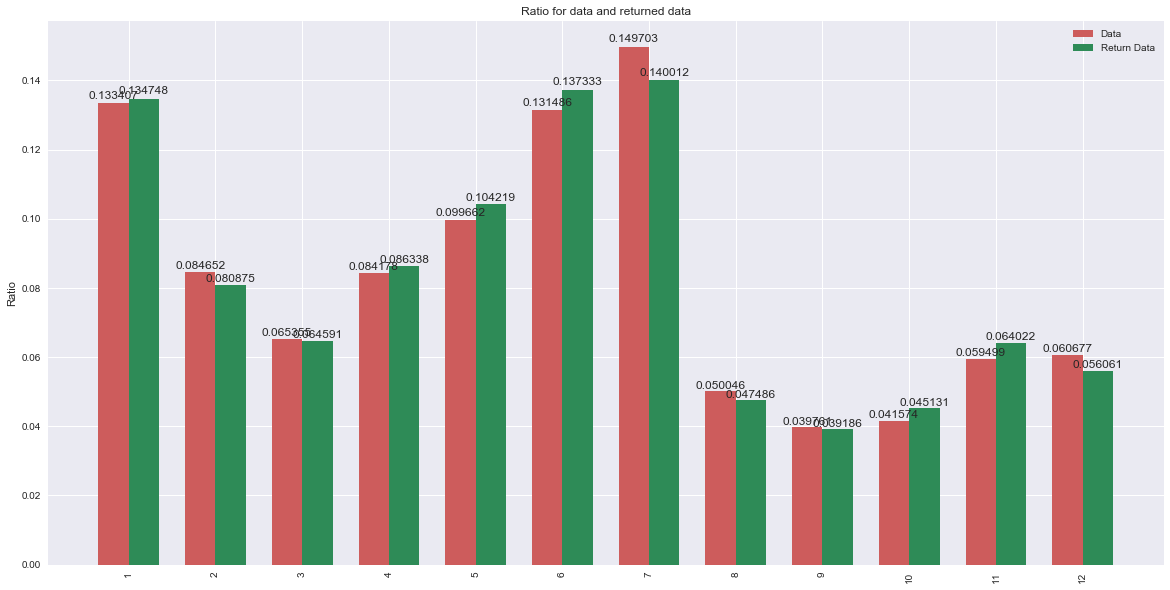

In [25]:
d = pd.crosstab(data['one'],ds,normalize='index')
returnd = pd.crosstab(returndata['one'],dsreturn,normalize='index')
label = d.columns.tolist()
liste1 = d.values[0]
liste2 = returnd.values[0]
# Plot the scores
N = len(label)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(ind, liste1, width, color='indianred')
rects2 = ax.bar(ind + width, liste2, width, color='seagreen')

# add some text for labels, title and axes ticks
ax.set_ylabel('Ratio')
ax.set_title('Ratio for data and returned data')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(label,rotation=90)
ax.legend((rects1[0], rects2[0]), ('Data', 'Return Data'))
    
autolabel(rects1)
autolabel(rects2)

plt.show()

###### Jour de la commande

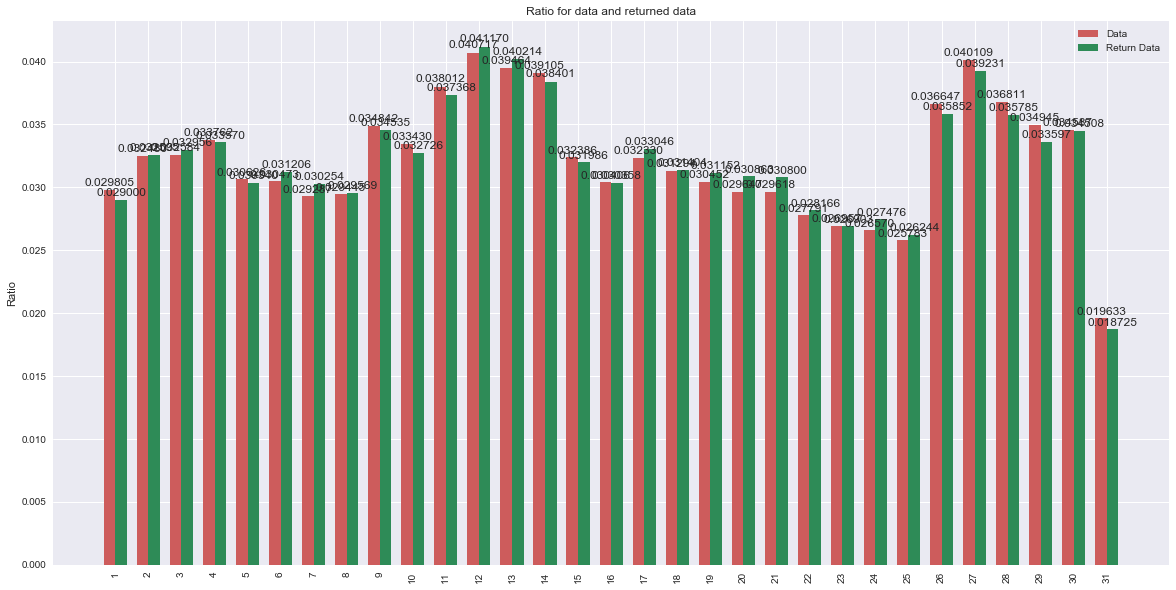

In [26]:
ds = data['OrderCreationDate'].apply(lambda x : x.day)
dsreturn = returndata['OrderCreationDate'].apply(lambda x : x.day)
d = pd.crosstab(data['one'],ds,normalize='index')
returnd = pd.crosstab(returndata['one'],dsreturn,normalize='index')
label = d.columns.tolist()
liste1 = d.values[0]
liste2 = returnd.values[0]
# Plot the scores
N = len(label)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(ind, liste1, width, color='indianred')
rects2 = ax.bar(ind + width, liste2, width, color='seagreen')

# add some text for labels, title and axes ticks
ax.set_ylabel('Ratio')
ax.set_title('Ratio for data and returned data')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(label,rotation=90)
ax.legend((rects1[0], rects2[0]), ('Data', 'Return Data'))
    
autolabel(rects1)
autolabel(rects2)

plt.show()

##### Heure de la commande

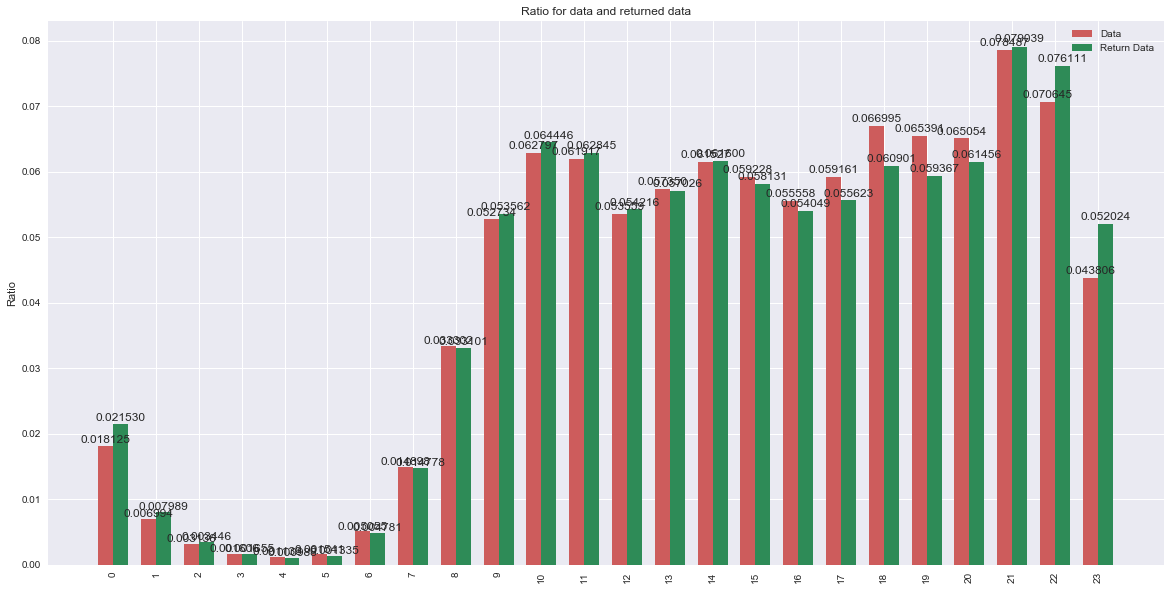

In [28]:
ds = data['OrderCreationDate'].apply(lambda x : x.hour)
dsreturn = returndata['OrderCreationDate'].apply(lambda x : x.hour)
d = pd.crosstab(data['one'],ds,normalize='index')
returnd = pd.crosstab(returndata['one'],dsreturn,normalize='index')
label = d.columns.tolist()
liste1 = d.values[0]
liste2 = returnd.values[0]
# Plot the scores
N = len(label)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(ind, liste1, width, color='indianred')
rects2 = ax.bar(ind + width, liste2, width, color='seagreen')

# add some text for labels, title and axes ticks
ax.set_ylabel('Ratio')
ax.set_title('Ratio for data and returned data')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(label,rotation=90)
ax.legend((rects1[0], rects2[0]), ('Data', 'Return Data'))
    
autolabel(rects1)
autolabel(rects2)

plt.show()

# Test

### Creation d'une colonne femme/fidélisée

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


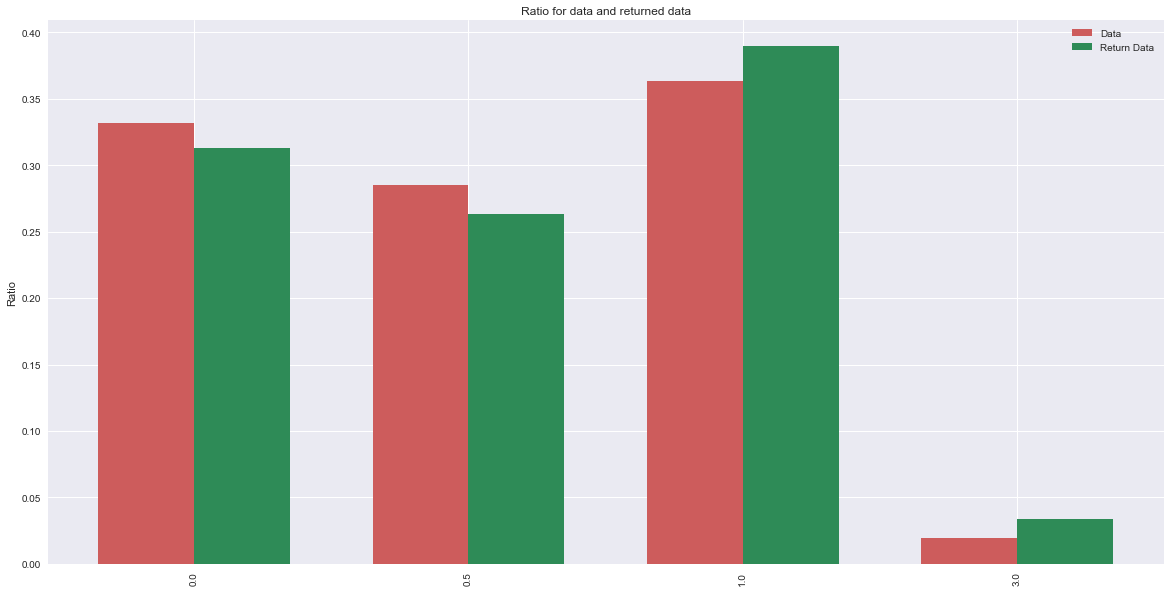

In [157]:

col1 = (data['CustomerTypeLabel'] == 'Fidélisé') & (data['Gender'] == 'Femme')
col2 = (data['CustomerTypeLabel'] == 'Fidélisé') & (data['Gender'] == 'Homme')
col3 = (data['CustomerTypeLabel'] == 'Nouveau') & (data['Gender'] == 'Femme')
col4 = (data['CustomerTypeLabel'] == 'Nouveau') & (data['Gender'] == 'Homme')
col5 = (data['CustomerTypeLabel'] == 'Fidélisé') & (data['Gender'] == 'Femme') & (data['ProductType'] == 'Escarpins')
data['femfid']=1*col1+0.5*col2+0.5*col3+0*col4+2*col5

returncol1 = (returndata['CustomerTypeLabel'] == 'Fidélisé') & (returndata['Gender'] == 'Femme')
returncol2 = (returndata['CustomerTypeLabel'] == 'Fidélisé') & (returndata['Gender'] == 'Homme')
returncol3 = (returndata['CustomerTypeLabel'] == 'Nouveau') & (returndata['Gender'] == 'Femme')
returncol4 = (returndata['CustomerTypeLabel'] == 'Nouveau') & (returndata['Gender'] == 'Homme')
returncol5 = (returndata['CustomerTypeLabel'] == 'Fidélisé') & (returndata['Gender'] == 'Femme') & (returndata['ProductType'] == 'Escarpins')
returndata['femfid']=1*returncol1+0.5*returncol2+0.5*returncol3+0*returncol4+2*returncol5

histogramme('femfid')